<a href="https://colab.research.google.com/github/Hrithik2212/-RNN-Sentimental-Analysis-on-Movie-Reviews---IMDB/blob/master/01_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
!nvidia-smi

Wed Aug 24 09:05:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |  11862MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import torch 
print(torch.__version__)

1.12.1+cu113


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

In [9]:
# imports
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from PIL import Image
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv 
from glob import glob
import torchsummary
import numpy as np, pandas as pd , matplotlib.pyplot as plt
import seaborn as sns 
from torch.utils.data import Dataset , DataLoader
from torchvision.datasets import ImageFolder
from torch.nn.modules.pooling import MaxPool2d
from pathlib import Path
import random
from PIL import Image 

## Data Preparation 

Random Image Path /content/drive/MyDrive/Data_Split/train/no/not_bands1361.jpg
Image Class no
Image Height 512
Imahe Width  512


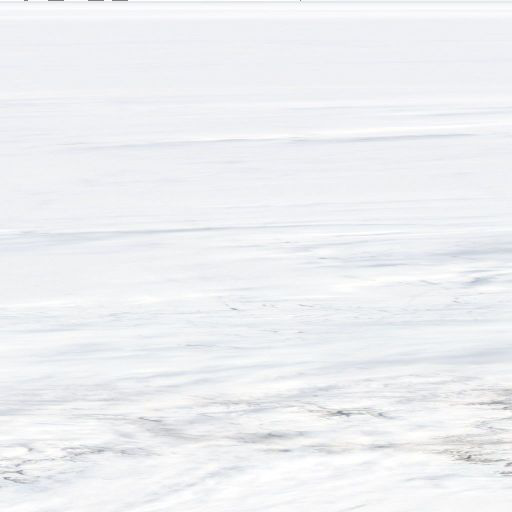

In [7]:
img_path = Path('/content/drive/MyDrive/Data_Split')
image_path_list = list(img_path.glob('*/*/*.jpg'))
rand_img_path = random.choice(image_path_list)

image_class = rand_img_path.parent.stem

img = Image.open(rand_img_path)

print(f'Random Image Path {rand_img_path}')
print(f'Image Class {image_class}')
print(f'Image Height {img.height}')
print(f'Imahe Width  {img.width}' )
img

In [80]:
import os 
def walk_through_dir(dir_path):
  for dirpath , dirnames , filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}')
walk_through_dir('/content/drive/MyDrive/Data_Split')

There are 3 directories and 0 files in /content/drive/MyDrive/Data_Split
There are 2 directories and 0 files in /content/drive/MyDrive/Data_Split/train
There are 0 directories and 1330 files in /content/drive/MyDrive/Data_Split/train/yes
There are 0 directories and 3439 files in /content/drive/MyDrive/Data_Split/train/no
There are 2 directories and 0 files in /content/drive/MyDrive/Data_Split/val
There are 0 directories and 380 files in /content/drive/MyDrive/Data_Split/val/yes
There are 0 directories and 982 files in /content/drive/MyDrive/Data_Split/val/no
There are 2 directories and 0 files in /content/drive/MyDrive/Data_Split/test
There are 0 directories and 493 files in /content/drive/MyDrive/Data_Split/test/no
There are 0 directories and 190 files in /content/drive/MyDrive/Data_Split/test/yes


In [81]:
train_dir = '/content/drive/MyDrive/Data_Split/train'
test_dir = '/content/drive/MyDrive/Data_Split/test'
val_dir = '/content/drive/MyDrive/Data_Split/val'

class TCB(Dataset):
  def __init__(self,folder):
    yes_jpg = glob(folder+'/yes/*.jpg')
    yes_png = glob(folder+'/yes/*.png')
    no_jpg = glob(folder+'/no/*.jpg')
    no_png = glob(folder+'/no/*.png')
    self.fpaths = yes_png + yes_jpg + no_png +no_jpg
    from random import shuffle, seed; seed(10);
    shuffle(self.fpaths)
    self.target = [fpath.split('/')[-2].startswith('yes') for fpath in self.fpaths] # 1 Prsent , 0 Not present 
  def __len__(self):
    return len(self.fpaths)
  
  def __getitem__(self , ix):
    fp = self.fpaths[ix]
    target = self.target[ix]
    im = np.asarray(Image.open(fp))
    im = cv.resize(im , (224,224))[:,:,::-1]
    if len(im.shape) > 2 and im.shape[2] == 4:
    #slice off the alpha channel
      im = im[:, :, :3]
    return torch.tensor(im/255).permute(2,0,1).to(device).float() , torch.tensor([target]).float().to(device)

Transverse Cirrus Band Present : 1 
 Transverse Cirrus Band not present : 0
Label : tensor([1.])


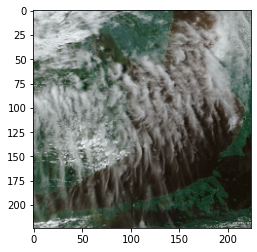

In [82]:
train_data = TCB(train_dir)
image ,label = train_data[1212]
print(f'Transverse Cirrus Band Present : 1 \n Transverse Cirrus Band not present : 0')
plt.imshow(image.permute(1,2,0).cpu())
print(f"Label : {label.cpu()}") 

In [83]:
len(train_data)

4769

In [84]:
val_data = TCB(val_dir)
test_data = TCB(test_dir)
len(val_data) , len(test_data)

(1362, 683)

In [116]:
def get_data():
    trn_dl = DataLoader(train_data, batch_size=64, shuffle=True, drop_last = True)
    val_dl = DataLoader(val_data, batch_size=64, shuffle=True, drop_last = True)
    test_dl = DataLoader(test_data, batch_size=len(test_data) , shuffle=False ,drop_last=True)
    return trn_dl, val_dl , test_dl

train_dl , val_dl , test_dl  = get_data()

## Model Building 

In [86]:
def conv_layer(ni , no , kernel , stride = 1 ):
    return nn.Sequential(
              nn.Conv2d(ni,no,kernel_size = kernel , stride = stride ) ,
              nn.ReLU(),
              nn.BatchNorm2d(no) ,
              nn.MaxPool2d(2)
          )

def get_model():
  model = nn.Sequential(
      conv_layer(3,64,3),
      conv_layer(64,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      nn.Flatten(),
      nn.Linear(512,1),
      nn.Sigmoid(),
  ).to(device)
  optimizer = torch.optim.Adam(model.parameters() , lr = 1e-3)
  loss_fn = nn.BCELoss()
  return model , optimizer ,loss_fn 

Model_0 , optimizer , loss_fn = get_model()

In [87]:
torchsummary.summary(Model_0 , (3,224 ,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

## Model Training 

In [88]:
# Training Function 
def train_batch(x,y,model,opt,loss_fn):
    model.train()
    y_preds = model(x)
    batch_loss = loss_fn(y_preds , y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

# Accuracy function 
@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()  

In [89]:
EPOCHS= 5
train_losses , train_accuricies = [] , []
val_losses , val_accuracies = [] , []
for epoch in range(EPOCHS):
    print(f'EPOCH {epoch+1}')
    train_epoch_losses , train_epoch_accuracies = [] , []
    val_epoch_accuracies = [] 
    for ix , batch in enumerate(iter(train_dl)):
        x  ,y = batch
        batch_loss = train_batch(x,y,Model_0,optimizer,loss_fn)
        train_epoch_losses.append(batch_loss)
        is_correct = accuracy(x , y, Model_0)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_loss = np.mean(train_epoch_losses)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix , batch in enumerate(iter(val_dl)):
        x , y = batch 
        val_is_crt = accuracy(x,y,Model_0)
        val_epoch_accuracies.extend(val_is_crt)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    print(f'Train Loss {train_epoch_loss:.4f} | Train Accuracy {train_epoch_accuracy:.2f} | Val Accuracy {val_epoch_accuracy:.2f}')
    print(f'Done============================================================')
    train_losses.append(train_epoch_loss)
    train_accuricies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

EPOCH 1
Train Loss 0.5058 | Train Accuracy 0.81 | Val Accuracy 0.84
Done============================================================
EPOCH 2
Train Loss 0.3594 | Train Accuracy 0.85 | Val Accuracy 0.84
Done============================================================
EPOCH 3
Train Loss 0.3456 | Train Accuracy 0.86 | Val Accuracy 0.85
Done============================================================
EPOCH 4
Train Loss 0.3181 | Train Accuracy 0.87 | Val Accuracy 0.85
Done============================================================
EPOCH 5
Train Loss 0.3076 | Train Accuracy 0.88 | Val Accuracy 0.85
Done============================================================


In [91]:
MORE_EPOCHS = 5
for epoch in range(MORE_EPOCHS):
    print(f'EPOCH {epoch+6}')
    train_epoch_losses , train_epoch_accuracies = [] , []
    val_epoch_accuracies = [] 
    for ix , batch in enumerate(iter(train_dl)):
        x  ,y = batch
        batch_loss = train_batch(x,y,Model_0,optimizer,loss_fn)
        train_epoch_losses.append(batch_loss)
        is_correct = accuracy(x , y, Model_0)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_loss = np.mean(train_epoch_losses)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix , batch in enumerate(iter(val_dl)):
        x , y = batch 
        val_is_crt = accuracy(x,y,Model_0)
        val_epoch_accuracies.extend(val_is_crt)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    print(f'Train Loss {train_epoch_loss:.4f} | Train Accuracy {train_epoch_accuracy:.2f} | Val Accuracy {val_epoch_accuracy:.2f}')
    print(f'Done============================================================')
    train_losses.append(train_epoch_loss)
    train_accuricies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

EPOCH 6
Train Loss 0.3035 | Train Accuracy 0.88 | Val Accuracy 0.85
Done============================================================
EPOCH 7
Train Loss 0.2932 | Train Accuracy 0.89 | Val Accuracy 0.87
Done============================================================
EPOCH 8
Train Loss 0.2838 | Train Accuracy 0.89 | Val Accuracy 0.85
Done============================================================
EPOCH 9
Train Loss 0.2646 | Train Accuracy 0.90 | Val Accuracy 0.87
Done============================================================
EPOCH 10
Train Loss 0.2644 | Train Accuracy 0.90 | Val Accuracy 0.86
Done============================================================


## Model Saving and Loading 

In [148]:
torch.save(Model_0.to('cpu').state_dict(), 'TCB_Classifier_V0.pth')

## Evaluation 

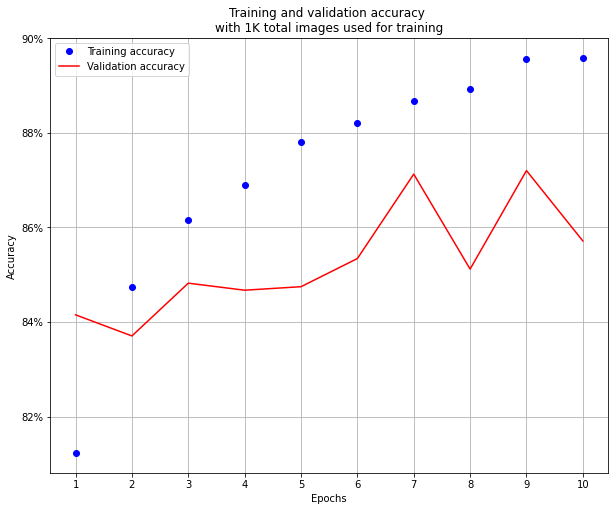

In [98]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.figure(figsize=(10,8))
plt.plot(epochs, train_accuricies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \nwith 1K total images used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [ ]:
accuracies = []
for batch in iter(test_dl):
    x , y = batch
    is_crt = accuracy(x,y,Model_0)
    accuracies.extend(is_crt)

In [115]:
np.mean(accuracies)

0.8546875

In [153]:
device

'cuda'

In [157]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [158]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
Model_0.eval()
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dl):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = Model_0.cuda()(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

RuntimeError: ignored